In [1]:
import os

import pandas as pd
from IPython.display import display

pd.options.display.float_format = '{:.4f}'.format
import warnings
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import *
from statsmodels.stats.multicomp import pairwise_tukeyhsd


warnings.filterwarnings("ignore")

In [2]:
data_path = "error_data.csv"
df = pd.read_csv(data_path, dtype={0: str, 1: str, 2: float})
display(df.head())

,Combination,Error Type,Error Value
0,01,MPJPE,31.5589
1,01,MPJPE,32.1064
2,01,MPJPE,35.3892
3,01,MPJPE,33.9654
4,01,MPJPE,30.7476


In [3]:
filtered_df = df[df['Combination'] != "04"]
mpjpe_filtered = filtered_df[filtered_df['Error Type'] == 'MPJPE'][['Combination', 'Error Value']]

subsets = [mpjpe_filtered[mpjpe_filtered['Combination'].str.len() == n]['Error Value'].values for n in range(2, 6)]
for i, subset in enumerate(subsets):
    print(f"C{i+2}: {len(subset)}")

C2: 16596
C3: 18440
C4: 9220
C5: 1844


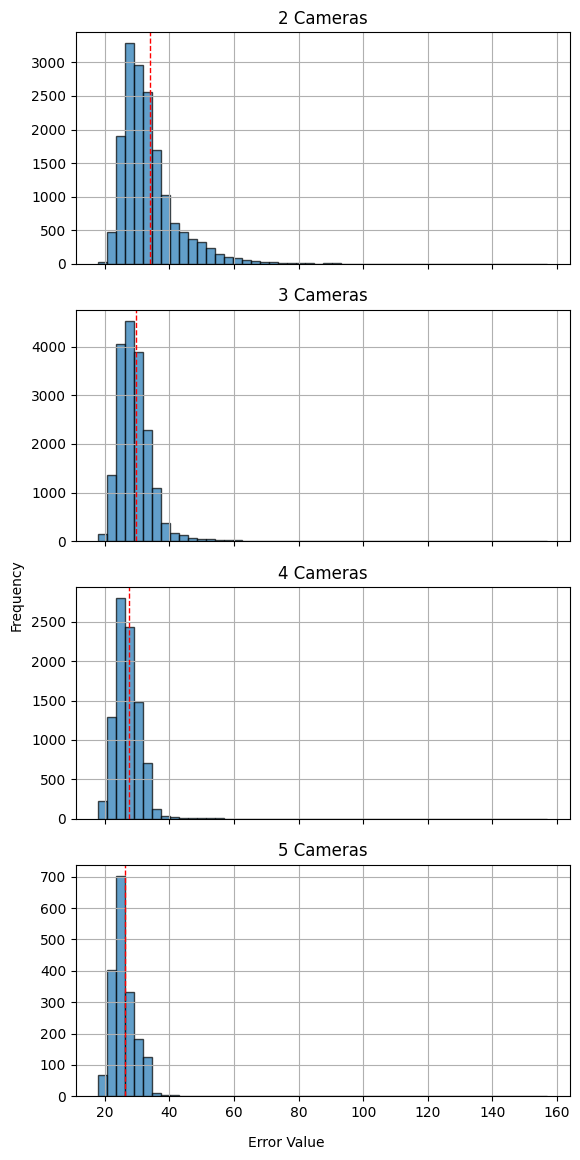

In [107]:
fig, ax = plt.subplots(4, 1, figsize=(6, 12), sharex=True)

x_max = max([subset.max() for subset in subsets])
x_min = min([subset.min() for subset in subsets])

for i, subset in enumerate(subsets):
    subset_mean = subset.mean()
    ax[i].hist(subset, bins=50, range=(x_min, x_max), alpha=0.7, edgecolor='black')
    ax[i].axvline(subset_mean, color='red', linestyle='dashed', linewidth=1)
    ax[i].set_title(f"{i + 2} Cameras")
    ax[i].grid(True)
    if i < 3:
        ax[i].set_xlabel("")

fig.text(0.5, 0.04, "Error Value", ha="center")
fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical")

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [108]:
def remove_outliers(subset: np.ndarray) -> np.ndarray:
    q1 = np.percentile(subset, 25)
    q3 = np.percentile(subset, 75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 + 2.5 * iqr
    return subset[(subset >= lower_bound) & (subset <= upper_bound)]

filtered_subsets = [remove_outliers(subset) for subset in subsets]

for i, filtered_subset in enumerate(filtered_subsets):
    print(f"C{i+2}: {len(filtered_subset)}")

C2: 16180
C3: 18083
C4: 9120
C5: 1827


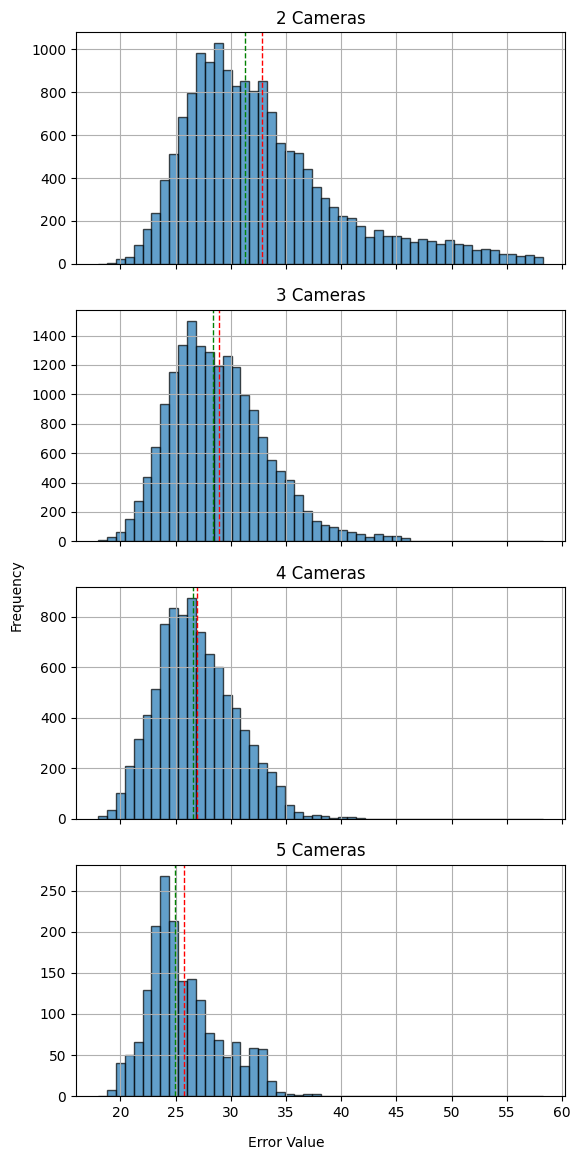

In [109]:
fig, ax = plt.subplots(4, 1, figsize=(6, 12), sharex=True)

x_max = max([filtered_subset.max() for filtered_subset in filtered_subsets])
x_min = min([filtered_subset.min() for filtered_subset in filtered_subsets])

for i, filtered_subset in enumerate(filtered_subsets):
    subset_mean = filtered_subset.mean()
    subset_median = np.median(filtered_subset)
    ax[i].hist(filtered_subset, bins=50, range=(x_min, x_max), alpha=0.7, edgecolor='black')
    ax[i].axvline(subset_mean, color='red', linestyle='dashed', linewidth=1)
    ax[i].axvline(subset_median, color='green', linestyle='dashed', linewidth=1)
    ax[i].set_title(f"{i + 2} Cameras")
    ax[i].grid(True)
    if i < 3:
        ax[i].set_xlabel("")

fig.text(0.5, 0.04, "Error Value", ha="center")
fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical")

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [110]:
ks_results = {}

for i in range(len(filtered_subsets)):
    for j in range(i + 1, len(filtered_subsets)):
        stat, p_value = ks_2samp(
            filtered_subsets[i],
            filtered_subsets[j]
        )
        ks_results[(i + 2, j + 2)] = {
            "stat": stat,
            "p_value": p_value
        }

ks_results_df = pd.DataFrame(ks_results).T
display(ks_results_df)

stat  p_value
2 3 0.2403   0.0000
  4 0.3913   0.0000
  5 0.5185   0.0000
3 4 0.1850   0.0000
  5 0.3416   0.0000
4 5 0.1896   0.0000

In [111]:
shapiro_results = {}

for i, filtered_subset in enumerate(filtered_subsets):
    stat, p_value = shapiro(filtered_subset)
    shapiro_results[i+2] = {
        "stat": stat,
        "p_value": p_value
    }

shapiro_results_df = pd.DataFrame(shapiro_results).T
display(shapiro_results_df)

,stat,p_value
2,0.9155,0.0000
3,0.9706,0.0000
4,0.9868,0.0000
5,0.9528,0.0000


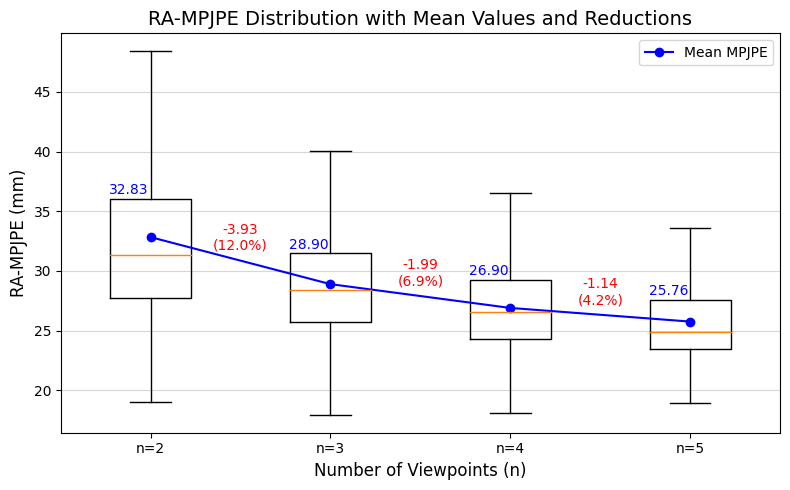

In [122]:
mean_values = [filtered_subset.mean() for filtered_subset in filtered_subsets]

plt.figure(figsize=(8, 5))
boxplot_data = []
q3_values = []

for i, filtered_subset in enumerate(filtered_subsets):
    boxplot_data.append(filtered_subset)
    q3_values.append(np.percentile(filtered_subset, 75))

plt.boxplot(boxplot_data, labels=[f"n={n}" for n in range(2, 6)], showfliers=False)

plt.plot(range(1, 5), mean_values, marker='o', linestyle='-', color='blue', label="Mean MPJPE")

for i, (start, end) in enumerate(zip(mean_values[:-1], mean_values[1:])):
    diff = start - end
    rate = diff / start * 100
    plt.text(i + 1.5, (start + end) / 2 + 0.9, f"-{diff:.2f}\n({rate:.1f}%)", ha='center', fontsize=10, color='red')

for i, (mean, q3) in enumerate(zip(mean_values, q3_values)):
    plt.text(i + 0.88, q3 + 0.4, f"{mean:.2f}", ha='center', fontsize=10, color='blue')

plt.title("RA-MPJPE Distribution with Mean Values and Reductions", fontsize=14)
plt.xlabel("Number of Viewpoints (n)", fontsize=12)
plt.ylabel("RA-MPJPE (mm)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [112]:
values_2, values_3, values_4, values_5 = filtered_subsets

stat_levene, p_levene = levene(values_2, values_3, values_4, values_5)
print(f"Levene's test: stat={stat_levene:.4f}, p={p_levene:.4f}")

stat_fligner, p_fligner = fligner(values_2, values_3, values_4, values_5)
print(f"Fligner-Killeen test: stat={stat_fligner:.4f}, p={p_fligner:.4f}")

Levene's test: stat=1239.3988, p=0.0000
Fligner-Killeen test: stat=3151.1833, p=0.0000


In [113]:
stat_kruskal, p_kruskal = kruskal(values_2, values_3, values_4, values_5)

def cliffs_delta(a, b):
    m, n = len(a), len(b)
    rank = np.argsort(np.concatenate([a, b]))
    a_ranks = np.sum(rank[:m])
    b_ranks = np.sum(rank[m:])
    return (2 * a_ranks / m - (m + 1)) / n - 0.5

cliffs_effects = {}
for i in range(len(filtered_subsets)):
    for j in range(i + 1, len(filtered_subsets)):
        delta = cliffs_delta(filtered_subsets[i], filtered_subsets[j])
        cliffs_effects[(i + 2, j + 2)] = delta

print(f"Kruskal-Wallis test: stat={stat_kruskal:.4f}, p={p_kruskal:.4f}")
cliffs_effects_df = pd.DataFrame(cliffs_effects, index=["Cliff's Delta"]).T
display(cliffs_effects_df)

Kruskal-Wallis test: stat=7251.7664, p=0.0000


Cliff's Delta
2 3         0.7221
  4         0.8941
  5         0.5883
3 4         0.6983
  5         0.6365
4 5         0.6203

In [114]:
values = np.concatenate([values_2, values_3, values_4, values_5])
groups = np.concatenate([
    np.repeat("2", len(values_2)),
    np.repeat("3", len(values_3)),
    np.repeat("4", len(values_4)),
    np.repeat("5", len(values_5))
])
unique_groups = np.unique(groups)
ranks = rankdata(values)

group_ranks = {g: ranks[groups == g] for g in unique_groups}
group_mean_ranks = {g: np.mean(group_ranks[g]) for g in unique_groups}
group_sizes = {g: len(group_ranks[g]) for g in unique_groups}
n_total = len(values)

dunn_results_with_z = {}
for g1, g2 in combinations(unique_groups, 2):
    diff = group_mean_ranks[g1] - group_mean_ranks[g2]
    se = np.sqrt((n_total * (n_total + 1)) / 12 * (1 / group_sizes[g1] + 1 / group_sizes[g2]))
    z = diff / se
    p = 2 * norm.sf(abs(z))
    dunn_results_with_z[(g1, g2)] = {"z": z, "p": p}

dunn_results_df = pd.DataFrame(dunn_results_with_z).T
display(dunn_results_df)

z      p
2 3 51.5909 0.0000
  4 74.9041 0.0000
  5 51.2908 0.0000
3 4 32.8970 0.0000
  5 28.8248 0.0000
4 5 11.1232 0.0000